In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df_data2 = df.iloc[:, 1:7]

df.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg

> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [3]:
# def has_cataract(text):
#     if "cataract" in text:
#         return 1
#     else:
#         return 0

In [4]:
def search_keywords(data_frame, keyword):
    left_diagnosis = data_frame[data_frame['Left-Diagnostic Keywords'].str.contains(keyword)]['Left-Fundus'].values
    right_diagnosis = data_frame[data_frame['Right-Diagnostic Keywords'].str.contains(keyword)]['Right-Fundus'].values
    combined = np.concatenate((left_diagnosis, right_diagnosis))
    
    return combined

# Mencari semua kata kunci dalam satu langkah
image_arrays = {}

# Daftar kata kunci yang ingin dicari
keywords = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

for keyword in keywords:
    images_for_keyword = search_keywords(df_data2, keyword)
    image_arrays[keyword] = images_for_keyword

# Menampilkan jumlah gambar untuk setiap kata kunci
for keyword, images in image_arrays.items():
    print(f"Number of images for {keyword}: {len(images)}")

# Combine all images for normal and conditions
all_images = np.concatenate(list(image_arrays.values()), axis=0)
print("Total number of images:", len(all_images))

# Convert image arrays to dictionary
class_images_dict = {keyword: images.tolist() for keyword, images in image_arrays.items()}

Number of images for cataract: 594
Number of images for normal: 5683
Number of images for myopia: 479
Number of images for hypertensive: 382
Number of images for diabetic: 165
Number of images for age-related macular degeneration: 551
Number of images for glaucoma: 616
Total number of images: 8470


In [5]:
# df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
# df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
# left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
# left_cataract[:15]

In [7]:
# right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
# right_cataract[:15]

In [8]:
# print("Number of images in left cataract: {}".format(len(left_cataract)))
# print("Number of images in right cataract: {}".format(len(right_cataract)))

>Normal Images

In [9]:
# left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
# right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
# right_normal[:15]

In [10]:
# cataract = np.concatenate((left_cataract,right_cataract),axis=0)
# normal = np.concatenate((left_normal,right_normal),axis=0)

In [11]:
# print(len(cataract),len(normal))

><h3>Creating Dataset from images</h3>

In [12]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from skimage import exposure

IMG_SIZE = 224

def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
    non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
    img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
    img = cv2.resize(img, target_shape)
    return img

# Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Fungsi untuk melakukan histogram equalization pada gambar
def histogram_equalization(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Lakukan histogram equalization
    equalized = cv2.equalizeHist(gray)
    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
    filtered = gaussian_blur(equalized)
    return filtered

# def histogram_equalization(image):
#     def linear_projection_block(x, output_dim):
#         x = np.reshape(x, (x.shape[0], -1))
#         x = np.dot(x, np.random.randn(x.shape[1], output_dim))
#         return x

#     def patch_position_embedding(x):
#         cls_token = x[0:1, :]  # Extract CLS token
#         position_embedding = np.expand_dims(x[1:, :], axis=1)  # Extract position embedding
#         x = np.concatenate([cls_token, position_embedding], axis=1)
#         return x

#     def transformer_encoder_block(x):
#         # Implementation of your Transformer Encoder Block
#         # You can use the transformer encoder implementation from libraries like TensorFlow or Hugging Face Transformers
#         # Here's a simplified version:
#         # For example:
#         # x = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)(x)
#         return x

#     def grading_prediction_block(x, num_classes):
#         class_features = []

#         # Generate multiple class features
#         for _ in range(num_classes):
#             class_feature = np.random.randn(x.shape[0], 1)
#             class_features.append(class_feature)

#         # Fuse class features by average pooling
#         fused_features = np.mean(class_features, axis=0)

#         # Classification result through an FC classifier
#         classification_result = np.random.randn(x.shape[0], num_classes)

#         return classification_result

#     # Initialize network parameters
#     num_heads = 8
#     ff_dim = 512
#     num_classes = 7
#     output_dim = 256
#     L = 3

#     # Image division Patch, that is, x is divided into 9 patches of fixed size.
#     patches = image_patches(image)

#     # Linear Projection of Flatted Patches
#     linear_projection = linear_projection_block(patches, output_dim)

#     # Patch + Position Embedding
#     patch_position_embedded = patch_position_embedding(linear_projection)

#     # Transformer Encoder
#     for _ in range(L):
#         transformer_output = transformer_encoder_block(patch_position_embedded)

#     # Grading Prediction Block
#     classification_result = grading_prediction_block(transformer_output, num_classes)

#     return classification_result

# # Fungsi untuk menghasilkan 9 patch dari gambar
# def image_patches(image):
#     patches = []

#     for i in range(3):
#         for j in range(3):
#             patch = image[i * 224:(i + 1) * 224, j * 224:(j + 1) * 224]
#             patches.append(patch)

#     return np.array(patches)

# # Fungsi untuk melakukan gaussian blur pada gambar
# def gaussian_blur(image):
#     # Ganti dengan implementasi fungsi gaussian blur sesuai kebutuhan
#     # Misalnya menggunakan cv2.GaussianBlur
#     blurred = cv2.GaussianBlur(image, (5, 5), 0)
#     return blurred

# def create_dataset_with_oversampling(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in tqdm(class_images_dict.items(), desc="Processing images"):
#         processed_images_count = 0  # Counter for successfully processed images
#         for img in tqdm(image_category, desc=f"Processing {class_name} images", leave=False):
#             image_path = os.path.join(dataset_dir, img)
#             try:
#                 # Load and preprocess image
#                 image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
                
#                 # Assuming the class labels are encoded as integers
#                 label = np.array(labels.index(class_name))
                
#                 dataset.append([np.array(image), label])
#                 processed_images_count += 1
#             except Exception as e:
#                 print(f"Error processing image {image_path}: {str(e)}")
#                 continue

#         print(f"Class {class_name}: Successfully processed {processed_images_count} images.")

#     # Convert the dataset to a DataFrame
#     df = pd.DataFrame(dataset, columns=['image', 'label'])

#     # Convert labels to integers explicitly
#     df['label'] = df['label'].astype(int)
    
#     # Check if df has data
#     if df.empty:
#         raise ValueError("Dataframe 'df' is empty. No data to oversample.")

#     # Apply random oversampling
#     oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
#     X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

#     # Reconstruct the dataset
#     resampled_dataset = [(X_resampled[i][0], y_resampled[i]) for i in range(len(X_resampled))]

#     random.shuffle(resampled_dataset)

#     # Print original class distribution
#     print("\nOriginal Class Distribution:")
#     for class_name in labels:
#         class_count = df[df['label'] == labels.index(class_name)]['label'].count()
#         print(f"{class_name}: {class_count}")

#     # Print oversampled class distribution
#     print("\nOversampled Class Distribution:")
#     resampled_df = pd.DataFrame({'label': y_resampled})
#     for class_name in labels:
#         class_count = resampled_df[resampled_df['label'] == labels.index(class_name)]['label'].count()
#         print(f"{class_name}: {class_count}")

#     return resampled_dataset, labels

def create_dataset_with_oversampling(dataset_dir, class_images_dict, image_size=(224, 224)):
    dataset = []
    labels = list(class_images_dict.keys())

    for class_name, image_category in class_images_dict.items():
        for img in tqdm(image_category, desc=f"Processing {class_name} images"):
            image_path = os.path.join(dataset_dir, img)
            try:
                image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
            except:
                continue

            # Assuming the class labels are encoded as integers
            label = np.array(labels.index(class_name))
            
            dataset.append([np.array(image), label])

    # Convert the dataset to a DataFrame
    df = pd.DataFrame(dataset, columns=['image', 'label'])

    # Convert labels to integers explicitly
    df['label'] = df['label'].astype(int)
    
     # Check if df has data
    if df.empty:
        raise ValueError("Dataframe 'df' is empty. No data to oversample.")

    # Apply random oversampling
    oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

    # Reconstruct the dataset
    resampled_dataset = [(X_resampled[i][0], y_resampled[i]) for i in range(len(X_resampled))]

    random.shuffle(resampled_dataset)

    # Print original class distribution
    print("Original Class Distribution:")
    for class_name in labels:
        class_count = df[df['label'] == labels.index(class_name)]['label'].count()
        print(f"{class_name}: {class_count}")

    # Print oversampled class distribution
    print("\nOversampled Class Distribution:")
    resampled_df = pd.DataFrame({'label': y_resampled})
    for class_name in labels:
        class_count = resampled_df[resampled_df['label'] == labels.index(class_name)]['label'].count()
        print(f"{class_name}: {class_count}")
    return resampled_dataset, labels

# Placeholder arrays, replace these with actual arrays when available
cataract = class_images_dict.get('cataract', [])
normal = class_images_dict.get('normal', [])
diabetic = class_images_dict.get('diabetic', [])
amd = class_images_dict.get('age-related macular degeneration', [])
glaucoma = class_images_dict.get('glaucoma', [])
myopia = class_images_dict.get('myopia', [])
hypertensive = class_images_dict.get('hypertensive', [])

# Assuming you have a dictionary of class images
class_images_dict = {
    'cataract': cataract,
    'normal': normal,
    'diabetic': diabetic,
    'age-related macular degeneration': amd,
    'glaucoma': glaucoma,
    'myopia': myopia,
    'hypertensive': hypertensive
}

dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
dataset, labels = create_dataset_with_oversampling(dataset_dir, class_images_dict)
print("Total number of images in the dataset:", len(dataset))

Processing cataract images:  24%|██▍       | 143/594 [00:02<00:06, 65.49it/s][ WARN:0@15.721] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.765] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
Processing normal images:   4%|▎         | 199/5683 [00:03<01:38, 55.91it/s][ WARN:0@24.219] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1062_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@24.238] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1077_left.jpg'): can't open/read file: check file path/integrity
Processing normal images:   8%|▊         | 427/5683 [00:07<01:21, 6

Original Class Distribution:
cataract: 588
normal: 5596
diabetic: 159
age-related macular degeneration: 551
glaucoma: 613
myopia: 473
hypertensive: 381

Oversampled Class Distribution:
cataract: 5596
normal: 5596
diabetic: 5596
age-related macular degeneration: 5596
glaucoma: 5596
myopia: 5596
hypertensive: 5596
Total number of images in the dataset: 39172


In [13]:
# from imblearn.under_sampling import RandomUnderSampler

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# # Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
# def gaussian_blur(image, kernel_size=(5, 5)):
#     return cv2.GaussianBlur(image, kernel_size, 0)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)
#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
#     filtered = gaussian_blur(equalized
#     return filtered

# def create_dataset_with_undersampling(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
#                 image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     # Convert the dataset to a DataFrame
#     df = pd.DataFrame(dataset, columns=['image', 'label'])

#     # Convert labels to integers explicitly
#     df['label'] = df['label'].astype(int)

#     # Apply random undersampling
#     undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
#     X_undersampled, y_undersampled = undersample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

#     # Reconstruct the dataset
#     undersampled_dataset = [(X_undersampled[i][0], y_undersampled[i]) for i in range(len(X_undersampled))]

#     random.shuffle(undersampled_dataset)

#     # Print original class distribution
#     print("Original Class Distribution:")
#     for class_name in labels:
#         class_count = df[df['label'] == labels.index(class_name)]['label'].count()
#         print(f"{class_name}: {class_count}")

#     # Print undersampled class distribution
#     print("\nUndersampled Class Distribution:")
#     undersampled_df = pd.DataFrame({'label': y_undersampled})
#     for class_name in labels:
#         class_count = undersampled_df[undersampled_df['label'] == labels.index(class_name)]['label'].count()
#         print(f"{class_name}: {class_count}")


#     return undersampled_dataset, labels

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# # Contoh penggunaan
# undersampled_dataset, labels = create_dataset_with_undersampling(dataset_dir, class_images_dict)
# print("Total number of images in the undersampled dataset:", len(undersampled_dataset))

In [14]:
# from imblearn.under_sampling import RandomUnderSampler

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# def median_filter(image, kernel_size):
#     # Pastikan ukuran kernel ganjil
#     if kernel_size % 2 == 0:
#         kernel_size += 1

#     # Lakukan filter median
#     filtered_image = cv2.medianBlur(image, kernel_size)

#     return filtered_image

# # Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
# def gaussian_blur(image, kernel_size=(5, 5)):
#     return cv2.GaussianBlur(image, kernel_size, 0)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
    
#     kernel_size = 5
    
#     filtered = gaussian_blur(equalized)
# #     filtered = median_filter(equalized, kernel_size)
# #     filtered = wiener_filter(equalized)

#     return filtered

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
#                 image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     # Convert the dataset to a DataFrame
#     df = pd.DataFrame(dataset, columns=['image', 'label'])

# #     # Convert labels to integers explicitly
# #     df['label'] = df['label'].astype(int)

# # #     # Apply random oversampling
# # #     oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
# # #     X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

# #     # Apply random undersampling
# #     undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# #     X_undersampled, y_undersampled = undersample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

# #     # Reconstruct the dataset
# #     undersampled_dataset = [(X_undersampled[i][0], y_undersampled[i]) for i in range(len(X_undersampled))]

# #     random.shuffle(undersampled_dataset)
#     # Convert labels to integers explicitly
#     df['label'] = df['label'].astype(int)

#     # Apply random undersampling
#     undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#     X_undersampled, y_undersampled = undersample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

#     # Reconstruct the dataset
#     undersampled_dataset = [(X_undersampled[i][0], y_undersampled[i]) for i in range(len(X_undersampled))]

#     random.shuffle(undersampled_dataset)

#     # Print original class distribution
#     print("Original Class Distribution:")
#     print(df['label'].value_counts())

#     # Print undersampled class distribution
#     print("\nUndersampled Class Distribution:")
#     undersampled_df = pd.DataFrame({'label': y_undersampled})
#     for class_name in labels:
#         class_count = undersampled_df[undersampled_df['label'] == class_name]['label'].count()
#         print(f"{class_name}: {class_count}")
        
#     return undersampled_dataset, labels

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

# # # # Print original class distribution
# # # print("Original Class Distribution:")
# # # print(df['label'].value_counts())

# # # # Print oversampled class distribution
# # # print("\nOversampled Class Distribution:")
# # # oversampled_df = pd.DataFrame({'label': y_resampled})
# # # for class_name in labels:
# # #     class_count = oversampled_df[oversampled_df['label'] == class_name]['label'].count()
# # #     print(f"{class_name}: {class_count}")

# # # Print undersampled class distribution
# # print("\nUndersampled Class Distribution:")
# # undersampled_df = pd.DataFrame({'label': y_undersampled})
# # for class_name in labels:
# #     class_count = undersampled_df[undersampled_df['label'] == class_name]['label'].count()
# #     print(f"{class_name}: {class_count}")

In [15]:
# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
# image_size=224
# target_size = (224, 224)  # Ubah ukuran sesuai kebutuhan Anda
# labels = []
# dataset = []
# def resize_image(img, target_size):
#     # Mendapatkan dimensi gambar asli
#     original_height, original_width = img.shape[:2]

#     # Mendapatkan dimensi target
#     target_width, target_height = target_size

#     # Menghitung rasio skala lebar dan tinggi
#     width_ratio = target_width / original_width
#     height_ratio = target_height / original_height

#     # Menentukan rasio skala yang akan digunakan untuk resizing
#     scale_ratio = min(width_ratio, height_ratio)

#     # Menghitung ukuran baru setelah penskalaan
#     new_width = int(original_width * scale_ratio)
#     new_height = int(original_height * scale_ratio)

#     # Melakukan resizing gambar dengan opsi interporasi yang baik
#     resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

#     # Membuat latar belakang gambar dengan ukuran target
#     background = (0, 0, 0)  # Hitam

#     # Membuat gambar dengan ukuran target yang tepat
#     top_padding = (target_height - new_height) // 2
#     bottom_padding = target_height - new_height - top_padding
#     left_padding = (target_width - new_width) // 2
#     right_padding = target_width - new_width - left_padding

#     # Menggunakan padding untuk membuat latar belakang dengan ukuran target
#     background_img = cv2.copyMakeBorder(resized_img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=background)

#     return background_img

# def crop_image(image_file):
#     img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
#     img_copy=img.copy()
#     lower=np.array([10,10,10])
#     higher=np.array([250,250,250])
#     mask=cv2.inRange(img, lower, higher)
#     contours, hierarchy = cv2.findContours(image= mask,
#                                            mode=cv2.RETR_EXTERNAL,
#                                            method=cv2.CHAIN_APPROX_NONE)
#     sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True) 

#     cont_img=cv2.drawContours(image=img, contours=sorted_contours, contourIdx=0, 
#                               color=(0,255,0),thickness=3)
#     c=sorted_contours[0]
#     x,y,w,h = cv2.boundingRect(c) 
#     cv2.rectangle(img=img, pt1=(x,y), pt2=(x+w,y+h), color=(0,255,0), thickness=3)
#     cropped_image=img_copy[y:y+h+1, x:x+w+1]
#     return cropped_image

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# def resize_and_crop_image(image_path, target_size):
#     # Read the image
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Resize the image
#     img = resize_image(img, target_size)

#     # Crop the image
#     img = crop_image(img)

#     return img

# def median_filter(image, kernel_size):
#     # Pastikan ukuran kernel ganjil
#     if kernel_size % 2 == 0:
#         kernel_size += 1

#     # Lakukan filter median
#     filtered_image = cv2.medianBlur(image, kernel_size)

#     return filtered_image

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
    
#     kernel_size = 5
    
# #     filtered = gaussian_blur(equalized)
#     filtered = median_filter(equalized, kernel_size)
# #     filtered = wiener_filter(equalized)

#     return filtered

# # def create_dataset(image_category,label):
# #     for img in tqdm(image_category):
# #         image_path = os.path.join(dataset_dir,img)
# #         try:
# # #             image = load_prep_img(image_path)
# #             image = cv2.imread(image_path,cv2.IMREAD_COLOR)
# # #             image = cv2.resize(image,(image_size,image_size))
# #             image = resize_image(image,target_size)
# #             image = crop_image(image)
# #         except:
# #             continue
        
# #         dataset.append([np.array(image),np.array(label)])
# #     random.shuffle(dataset)
# #     return dataset

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
# #                 image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#                 image = load_prep_img(image_path)
# #                 image = cv2.resize(image, image_size)
#                 image = histogram_equalization(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     random.shuffle(dataset)
#     return dataset, labels

# # Placeholder arrays, replace these with actual arrays when available
# cataract = class_images_dict.get('cataract', [])
# normal = class_images_dict.get('normal', [])
# diabetic = class_images_dict.get('diabetic', [])
# amd = class_images_dict.get('age-related macular degeneration', [])
# glaucoma = class_images_dict.get('glaucoma', [])
# myopia = class_images_dict.get('myopia', [])
# hypertensive = class_images_dict.get('hypertensive', [])

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

In [16]:
# dataset = create_dataset(cataract,1)

In [17]:
# len(dataset)

In [18]:
# dataset = create_dataset(normal,0)

In [19]:
# len(dataset)

In [20]:
# # Assuming y_train_labels is your target variable after oversampling
# class_labels, class_counts = np.unique(y_train_labels, return_counts=True)

# plt.bar(class_labels, class_counts, align='center')
# plt.xlabel('Class Labels')
# plt.ylabel('Count')
# plt.title('Class Distribution after Oversampling')
# plt.show()

><h3>Let's see some images</h3>

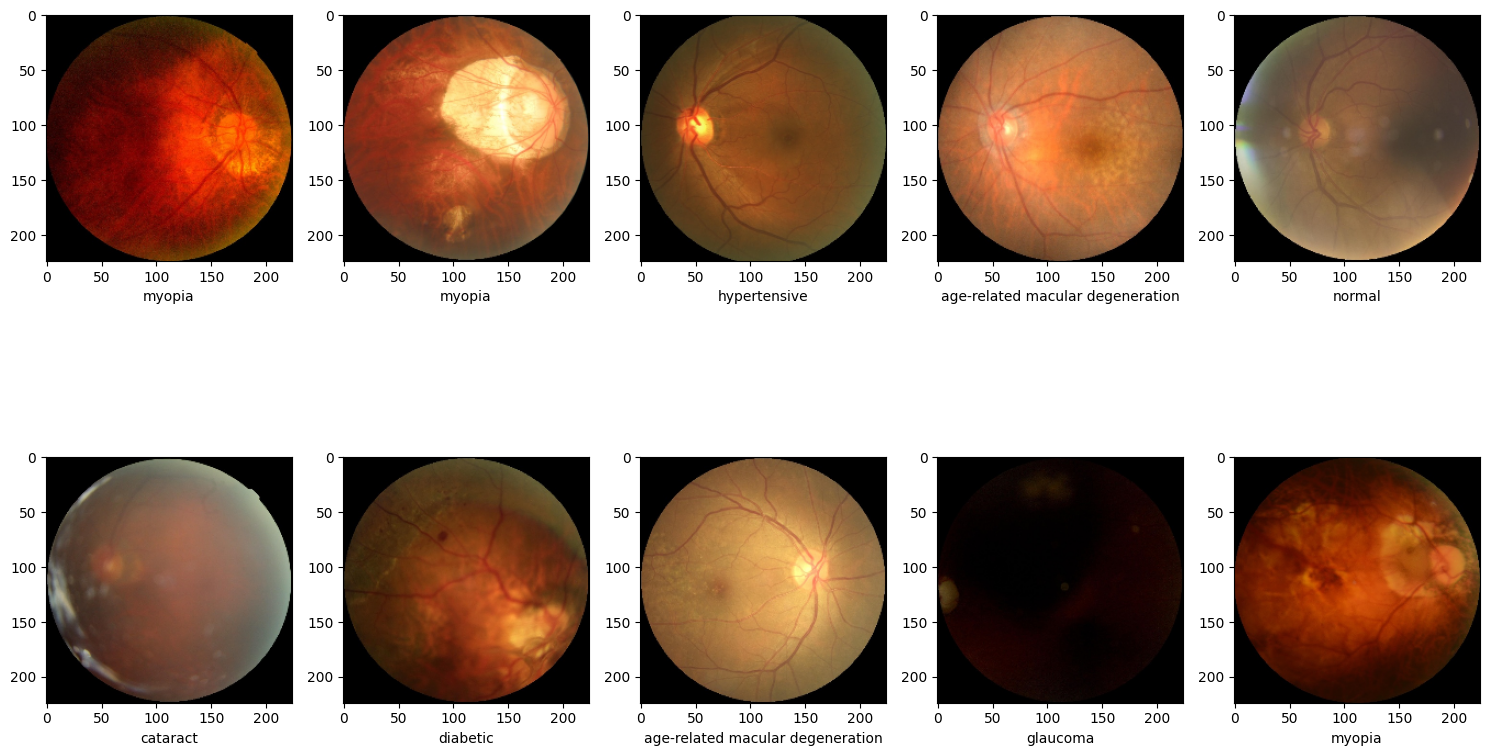

In [21]:
# plt.figure(figsize=(12,7))
# for i in range(10):
#     sample = random.choice(range(len(dataset)))
#     image = dataset[sample][0]
#     category = dataset[sample][1]
#     if category== 0:
#         label = "Normal"
#     else:
#         label = "Cataract"
#     plt.subplot(2,5,i+1)
#     plt.imshow(image)
#     plt.xlabel(label)
# plt.tight_layout()

# Gantilah X dan y dengan variabel yang sesuai pada saat membuat dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    label_id = dataset[sample][1]
    
    # Konversi label_id ke label yang sesuai
    labels = ['cataract', 'normal', 'diabetic', 'age-related macular degeneration', 'glaucoma', 'myopia', 'hypertensive']
    label = labels[label_id]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()
plt.show()

><h3>Dividing dataset into x(features) & y(target)</h3>

In [22]:
# x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
# y = np.array([i[1] for i in dataset])
from tensorflow.keras.utils import to_categorical
# Assuming num_classes is defined and set to 7
num_classes = len(class_images_dict)

# Convert labels to one-hot encoded format
y = np.array([i[1] for i in dataset])
y_onehot = to_categorical(y, num_classes=num_classes)

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# # # x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

# Split the dataset into training and testing sets
image_size=224
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

# # Assuming x and y_onehot are your data and one-hot encoded labels
# x_train, x_test, y_train_onehot, y_test_onehot = train_test_split(x, y_onehot, test_size=0.3)

# # Convert one-hot encoded labels to categorical labels
# y_train_labels = np.argmax(y_train_onehot, axis=1)
# y_test_labels = np.argmax(y_test_onehot, axis=1)

# def preprocess_transformer_data(data):
#     # Sesuaikan dengan persiapan data yang dibutuhkan oleh model Transformer
#     # Contoh: Normalisasi, resizing, atau transformasi lainnya
    
#     # Misalnya, normalisasi data ke rentang [0, 1]
#     preprocessed_data = data / 255.0
    
#     return preprocessed_data

# # Assuming num_classes is defined and set to 7
# num_classes = len(class_images_dict)

# # Convert labels to one-hot encoded format
# y = np.array([i[1] for i in dataset])
# y_onehot = to_categorical(y, num_classes=num_classes)

# # Split the dataset into training and testing sets
# image_size = 224
# x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)

# # Split data into VGG and Transformer inputs
# x_train_vgg, x_test_vgg, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

# # Assuming x_transformer is derived from x (modify this part based on your actual data)
# x_transformer = preprocess_transformer_data(x)  # Adjust based on your preprocessing function for the Transformer

><h3>Creating Model</h3>

In [24]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# import datetime
# from tensorflow.keras.callbacks import TensorBoard
# import numpy as np
# import random

# # Assuming num_classes is defined and set to 7
# num_classes = 7

# # Convert labels to one-hot encoded format
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# # Assuming image size is defined
# image_size = 224

# # Preprocess input data (VGG19-specific)
# x_train_preprocessed = preprocess_input(x_train)
# x_test_preprocessed = preprocess_input(x_test)

# # Create your model architecture
# def create_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    
#     for layer in vgg.layers:
#         layer.trainable = False
    
#     model = Sequential()
#     model.add(vgg)
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation="softmax"))
    
#     optimizer = Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Define callbacks
# checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
# earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# # Create and compile the model
# model = create_model((image_size, image_size, 3), num_classes)

# # Train the model
# history = model.fit(x_train_preprocessed, y_train_onehot, validation_data=(x_test_preprocessed, y_test_onehot),
#                     epochs=50, batch_size=32, callbacks=[checkpoint, earlystop, reduce_lr])

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test_preprocessed, y_test_onehot)
# print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# # Define your model architecture (as you provided)
# def create_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
    
#     for layer in vgg.layers:
#         layer.trainable = False
    
#     model = Sequential()
#     model.add(vgg)
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation="softmax"))
    
# #     model.summary()

#     optimizer = Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Load your data and create datasets
# # Assuming x_train, y_train, x_test, y_test are already defined

# # Assuming num_classes is defined and set to 7
# num_classes = 7

# # Convert labels to one-hot encoded format
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# # Assuming image size is defined
# image_size = 224

# # Create multiple instances of the model
# num_models = 5  # You can adjust the number of models based on your preference
# models = [create_model((image_size, image_size, 3), num_classes) for _ in range(num_models)]

# # Training each model independently
# histories = []
# for i, model in enumerate(models):
#     print(f"Training Model {i + 1}")
    
#     checkpoint = ModelCheckpoint(f'model_{i + 1}.h5', monitor='val_loss', save_best_only=True, verbose=1,
#                                  save_weights_only=False, period=1)
#     earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#     lr_scheduler = LearningRateScheduler(lambda epoch: 0.01 if epoch > 10 else (0.1 if epoch > 5 else 1.0))

#     history = model.fit(x_train, y_train_onehot, steps_per_epoch=len(x_train) / 32, batch_size=32, epochs=50,
#                         validation_data=(x_test, y_test_onehot), verbose=1, callbacks=[checkpoint, earlystop, lr_scheduler])
    
#     histories.append(history)

# # Combine logits (predictions before softmax) from all models
# ensemble_logits = np.zeros_like(y_test_onehot)
# for model in models:
#     ensemble_logits += model.predict(x_test, logits=True)  # Ensure your model has logits=True

# # Average logits from all models
# ensemble_logits /= num_models

# # Convert logits to probabilities using softmax
# ensemble_predictions_prob = softmax(ensemble_logits, axis=1)

# print(f"Ensemble Model - Loss: {ensemble_loss:.4f}, Accuracy: {ensemble_accuracy * 100:.2f}%")

In [25]:
# import datetime
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, models
# from tensorflow.keras.layers import Input, concatenate
# from tensorflow.keras import Sequential
# from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
# from keras import applications, regularizers
# from keras.optimizers import Adam

# def linear_projection_block(x, output_dim):
#     x = layers.Dense(output_dim)(x)
#     return x

# def patch_position_embedding(x):
#     cls_token = layers.Lambda(lambda x: x[:, 0:1, :])(x)  # Extract CLS token
#     position_embedding = layers.Lambda(lambda x: x[:, 1:, :])(x)  # Extract position embedding
#     x = layers.Concatenate(axis=1)([cls_token, position_embedding])
#     return x

# def transformer_encoder_block(x, num_heads, ff_dim, dropout_rate=0.1):
#     # Implementation of your Transformer Encoder Block
#     # You can use the transformer encoder implementation from libraries like TensorFlow or Hugging Face Transformers
#     # Here's a simplified version:
#     # For example:
#     # x = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)(x)
#     return x

# def grading_prediction_block(x, num_classes):
#     class_features = []
    
#     # Generate multiple class features
#     for _ in range(num_classes):
#         class_feature = layers.Conv2D(1, (1, 1), activation='relu')(x)
#         class_feature = layers.Flatten()(class_feature)
#         class_features.append(class_feature)

#     # Fuse class features by average pooling
#     fused_features = layers.Average()(class_features)

#     # Classification result through an FC classifier
#     classification_result = layers.Dense(num_classes, activation='softmax')(fused_features)

#     return classification_result


# # Fungsi pembuatan model Transformer
# def create_model(input_shape, num_heads, ff_dim, num_classes, output_dim, L):
#     # Input
#     input_layer = layers.Input(shape=input_shape)

#     # Feature Extraction Block (FEB)
#     linear_projection = linear_projection_block(input_layer, output_dim)
#     patch_position_embedded = patch_position_embedding(linear_projection)
    
#     # Transformer Encoder Block (Repeat stacking L times)
#     for _ in range(L):
#         transformer_output = transformer_encoder_block(patch_position_embedded, num_heads, ff_dim)

#     # Grading Prediction Block
#     classification_result = grading_prediction_block(transformer_output, num_classes)

#     # Model
#     model = models.Model(inputs=input_layer, outputs=classification_result)

#     return model

# # Fungsi untuk menggabungkan model VGG19 dan model Transformer
# def combine_models(vgg_model, transformer_model, num_classes):
#     # Get the output layer of the VGG model
#     vgg_output = vgg_model.layers[-2].output

#     # Get the output layer of the Transformer model
#     transformer_output = transformer_model.layers[-1].output

#     # Menggabungkan output dari kedua model
#     combined_output = concatenate([vgg_output, transformer_output])

#     # Tambahkan lapisan Dense untuk prediksi kelas
#     x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined_output)
#     x = BatchNormalization()(x)
#     x = Dropout(0.25)(x)
#     x = Dense(num_classes, activation='softmax')(x)

#     # Gabungkan input dan output menjadi model gabungan
#     combined_model = Model(inputs=[vgg_model.input, transformer_model.input], outputs=x)

#     return combined_model

# # Fungsi pembuatan model VGG19
# def create_vgg19_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)

#     # Menghentikan pelatihan VGG19
#     for layer in vgg.layers:
#         layer.trainable = False

#     # Membangun model
#     x = Flatten()(vgg.output)
#     x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.25)(x)
#     x = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=vgg.input, outputs=x)

#     return model

# # Inisialisasi parameter
# input_shape_vgg = (224, 224, 3)
# num_heads = 8
# ff_dim = 512
# num_classes = 7
# output_dim = 256
# L = 3

# # Membuat model VGG19 dan Transformer
# input_shape_transformer = (224, 224, 3)  # Sesuaikan dengan bentuk input Transformer
# vgg_model = create_vgg19_model(input_shape_vgg, num_classes)
# transformer_model = create_model(input_shape_transformer, num_heads, ff_dim, num_classes, output_dim, L)

# # Membuat model gabungan
# combined_model = combine_models(vgg_model, transformer_model, num_classes)

# # Menampilkan ringkasan model gabungan
# combined_model.summary()

# # Split data
# x_train_vgg, x_test_vgg, x_train_transformer, x_test_transformer, y_train, y_test = train_test_split(
#     x, x_transformer, y_onehot, test_size=0.3
# )

# # Kompilasi model gabungan
# optimizer = Adam(learning_rate=0.01)
# combined_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# checkpoint_combined = ModelCheckpoint('model_combined.save', monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False, period=1)
# earlystop_combined = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# log_dir_combined = "logs/fit_combined/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback_combined = TensorBoard(log_dir=log_dir_combined, histogram_freq=1)

# # Learning Rate Schedule
# def lr_schedule_combined(epoch):
#     lr = 0.01
#     if epoch > 10:
#         lr *= 0.1
#     elif epoch > 5:
#         lr *= 0.5
#     return lr

# lr_scheduler_combined = LearningRateScheduler(lr_schedule_combined)

# # Train the combined model
# history_combined = combined_model.fit(
#     [x_train_vgg, x_train_transformer], y_train,
#     steps_per_epoch=len(x_train_vgg) / 128, batch_size=128,
#     epochs=15, validation_data=([x_test_vgg, x_test_transformer], y_test),
#     verbose=1, callbacks=[checkpoint_combined, earlystop_combined, lr_scheduler_combined, tensorboard_callback_combined]
# )

In [26]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 3s 0us/step


In [27]:
for layer in vgg.layers:
    layer.trainable = False

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras import applications, regularizers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(7,activation="sigmoid"))
# Definisikan parameter untuk pelatihan model

num_classes = 7

model = Sequential()
model.add(vgg)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(num_classes,activation="softmax"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 256)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0         
                                                        

In [30]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning Rate Schedule
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [31]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
# checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_loss",verbose=1,save_best_only=True,
#                              save_weights_only=False,period=1)
# earlystop = EarlyStopping(monitor="val_loss",patience=5,verbose=1)

checkpoint = ModelCheckpoint('model_vgg19.save', monitor='val_loss', save_best_only=True, verbose=1,save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
log_dir = "logs/fit_vgg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
history = model.fit(x_train,y_train,steps_per_epoch=len(x_train) / 128, batch_size=128,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop, lr_scheduler])

# from sklearn.utils.class_weight import compute_sample_weight

# # Calculate class weights
# sample_weights = compute_sample_weight('balanced', y_train_labels)

# # Convert class weights to a dictionary
# class_weight_dict = dict(zip(np.unique(y_train_labels), sample_weights))

# # Use class weights in model.fit
# history = model.fit(x_train, y_train, steps_per_epoch=len(x_train) / 32, batch_size=32, epochs=15, validation_data=(x_test, y_test),
#                     class_weight=class_weight_dict, verbose=1, callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/15
215/214 [==============================] - ETA: 0s - loss: 1.9583 - accuracy: 0.5358
Epoch 1: val_loss improved from inf to 3.12684, saving model to model_vgg19.save
214/214 [==============================] - 108s 451ms/step - loss: 1.9583 - accuracy: 0.5358 - val_loss: 3.1268 - val_accuracy: 0.2538 - lr: 0.0100
Epoch 2/15
215/214 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.7834
Epoch 2: val_loss improved from 3.12684 to 2.46279, saving model to model_vgg19.save
214/214 [==============================] - 83s 388ms/step - loss: 1.1689 - accuracy: 0.7834 - val_loss: 2.4628 - val_accuracy: 0.4859 - lr: 0.0100
Epoch 3/15
215/214 [==============================] - ETA: 0s - loss: 1.2599 - accuracy: 0.8570
Epoch 3: val_loss did not improve from 2.46279
214/214 [==============================] - 80s 375ms/step - loss: 1.2599 - accuracy: 0.8570 - val_loss: 6280.4038 - val_accuracy: 0.1429 - lr: 0.0100
Epoch 4/15
215/214 [==============================] - 

In [33]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

368/368 [==============================] - 31s 78ms/step - loss: 1.8148 - accuracy: 0.6851
loss: 1.814828872680664
Accuracy: 0.6850748658180237


In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = model.predict_classes(x_test)

# Assuming model.predict returns probabilities for each class
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels (use argmax along axis 1)
y_pred = np.argmax(y_pred_prob, axis=1)

# If y_test is one-hot encoded, convert it back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# print("Shape of y_test_labels:", y_test_labels.shape)
# print("Shape of y_pred:", y_pred.shape)

368/368 [==============================] - 27s 72ms/step


In [35]:
model.save("eyedisease.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# accuracy_score(y_test,y_pred)

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.685074880871341


In [37]:
# print(classification_report(y_test,y_pred))

# Assuming y_test_labels and y_pred are available
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1744
           1       0.38      0.88      0.53      1655
           2       0.80      0.69      0.74      1672
           3       0.90      0.32      0.47      1681
           4       0.85      0.36      0.50      1625
           5       0.89      0.91      0.90      1679
           6       0.69      0.75      0.72      1696

    accuracy                           0.69     11752
   macro avg       0.78      0.68      0.68     11752
weighted avg       0.78      0.69      0.68     11752



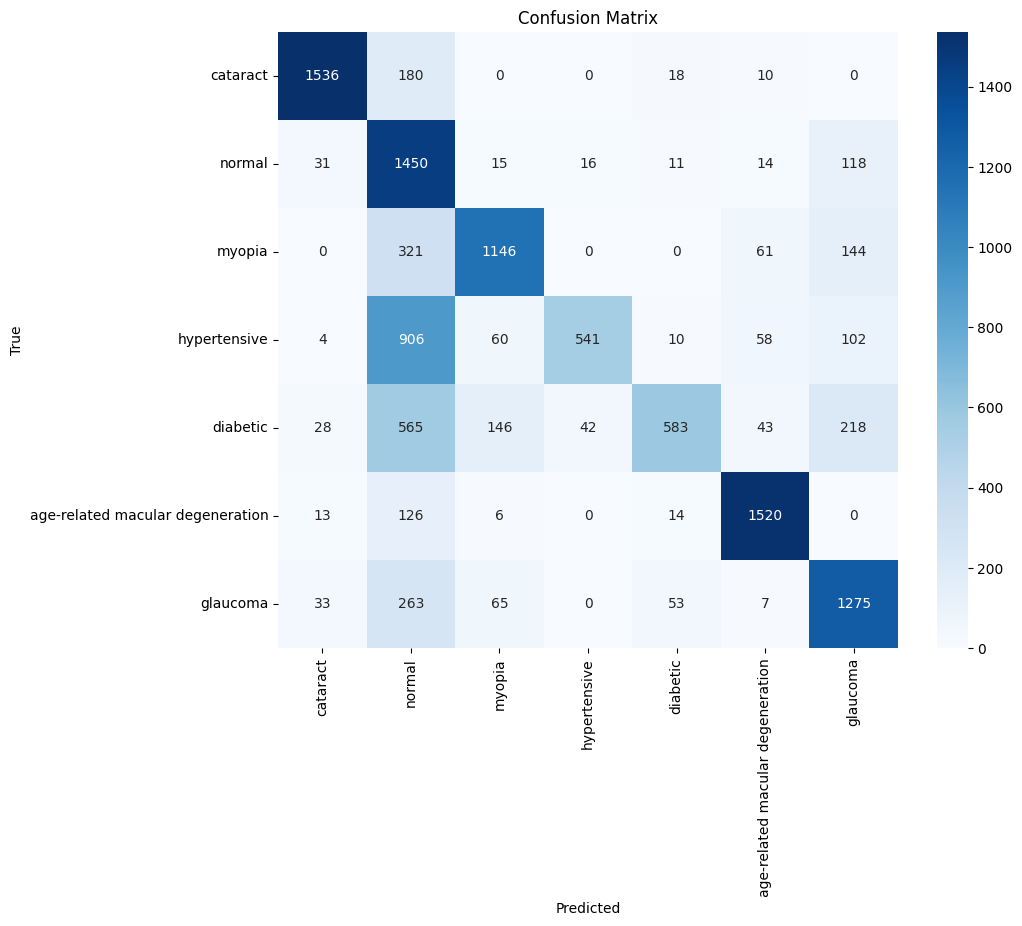

                                  precision    recall  f1-score   support

                        cataract       0.93      0.88      0.91      1744
                          normal       0.38      0.88      0.53      1655
                          myopia       0.80      0.69      0.74      1672
                    hypertensive       0.90      0.32      0.47      1681
                        diabetic       0.85      0.36      0.50      1625
age-related macular degeneration       0.89      0.91      0.90      1679
                        glaucoma       0.69      0.75      0.72      1696

                        accuracy                           0.69     11752
                       macro avg       0.78      0.68      0.68     11752
                    weighted avg       0.78      0.69      0.68     11752



In [38]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
# cm = confusion_matrix(y_test,y_pred)
# plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
#                       show_normed = True);


# Assuming y_test_labels and y_pred are available
le = LabelEncoder()
y_test_labels_encoded = le.fit_transform(y_test_labels)
y_pred_encoded = le.transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels_encoded, y_pred_encoded)
class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print(classification_report(y_test_labels_encoded, y_pred_encoded, target_names=class_names))

><h3>Learning Curve</h3>

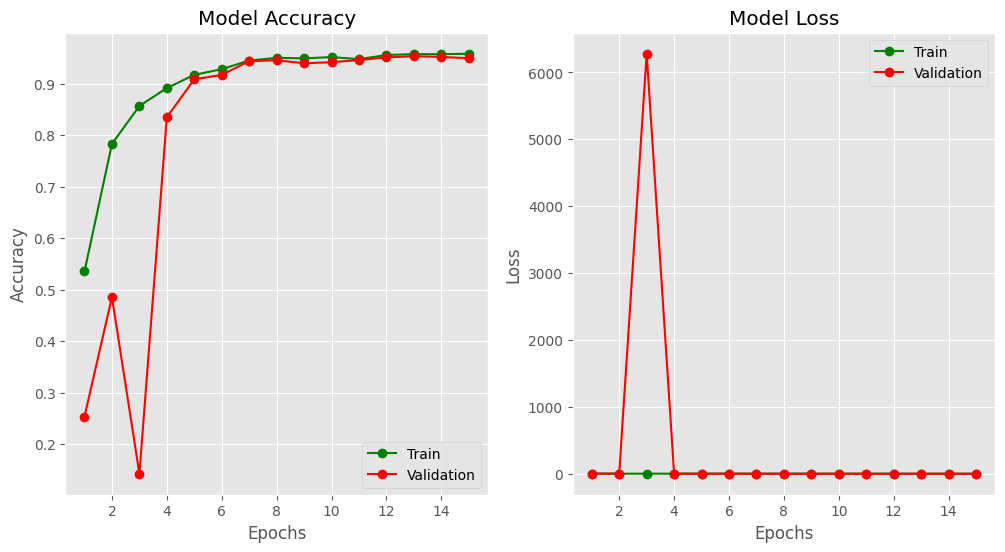

In [39]:
# plt.style.use("ggplot")
# fig = plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],"go-")
# plt.plot(epochs,history.history["val_accuracy"],"ro-")
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Train","val"],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],"go-")
# plt.plot(epochs,history.history["val_loss"],"ro-")
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Train","val"],loc = "upper left")
# plt.show()

plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

# Extract the actual number of epochs from the training history
epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

plt.show()

><h3>Prediction:</h3>

1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 23ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 23ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 23ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 27ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 24ms/step
Predicted Class: myopia, Confidence: 100.00%


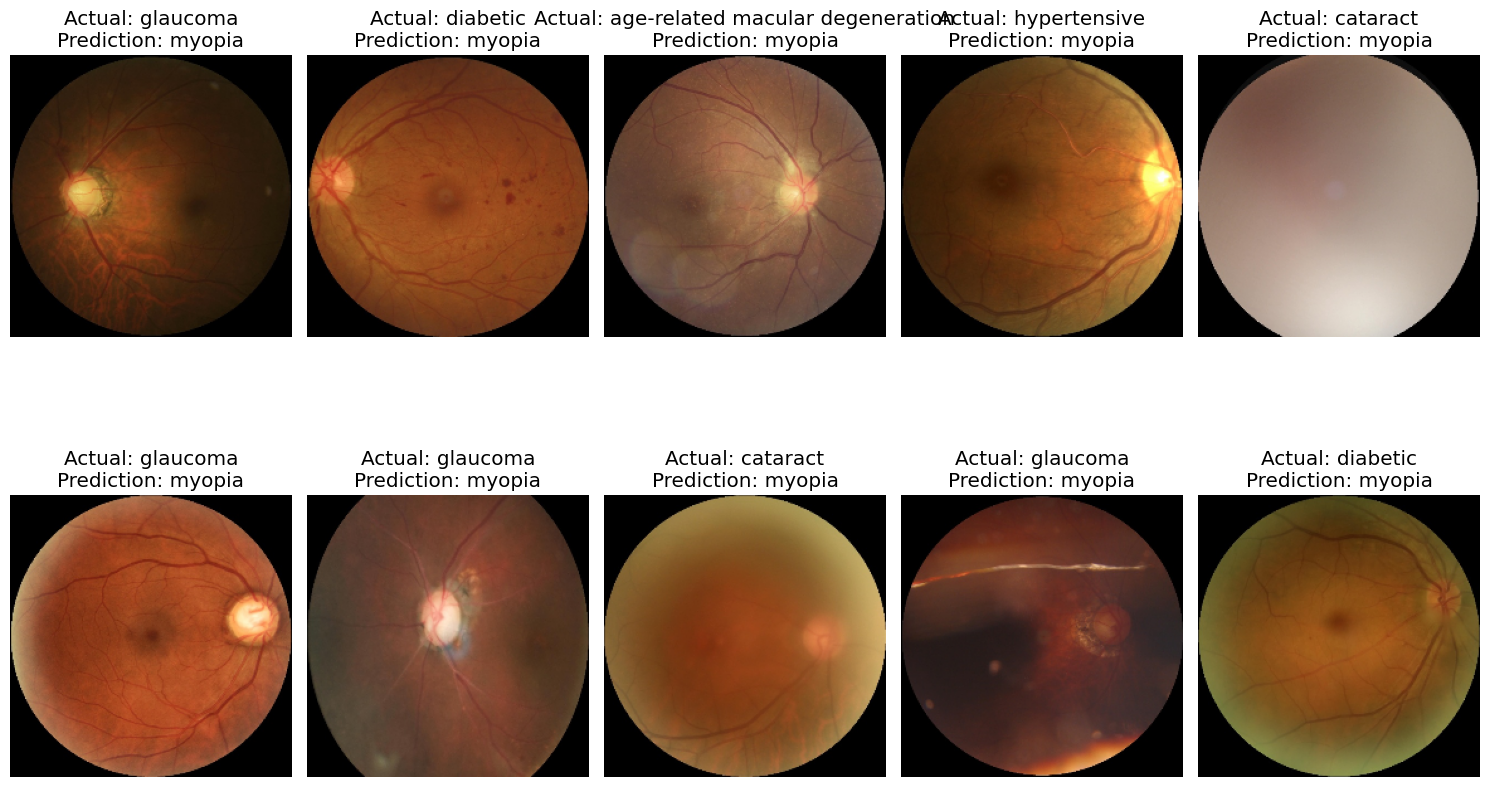

In [40]:
from tensorflow.keras.applications.vgg19 import preprocess_input
# plt.figure(figsize=(12,7))
# for i in range(10):
#     sample = random.choice(range(len(x_test)))
#     image = x_test[sample]
#     category = y_test[sample]
#     pred_category = y_pred[sample]
    
#     if category== 0:
#         label = "Normal"
#     else:
#         label = "Cataract"      
#     if pred_category== 0:
#         pred_label = "Normal"
#     else:
#         pred_label = "Cataract"   
#     plt.subplot(2,5,i+1)
#     plt.imshow(image)
#     plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
# plt.tight_layout() 

def prediksi(image):
    output = {0: 'cataract', 1: 'normal', 2: 'diabetic', 3: 'age-related macular degeneration',
              4: 'glaucoma', 5: 'myopia', 6: 'hypertensive'}
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rbg = cv2.resize(rgb, (image_size, image_size))
    predictions = model.predict(np.array([rbg]))
    return output[np.argmax(predictions)], np.max(predictions) * 100

# Map class indices to class names
class_names = {0: 'cataract', 1: 'normal', 2: 'diabetic', 3: 'age-related macular degeneration',
               4: 'glaucoma', 5: 'myopia', 6: 'hypertensive'}

plt.figure(figsize=(15, 10))

# Select a random sample of images
for i in range(10):
    sample_index = random.choice(range(len(x_test)))
    image = x_test[sample_index]
    actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

    # Ensure that the input image has the correct shape
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

    pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

    # Select the top predicted class
    pred_category = class_names[np.argmax(pred_category_probs)]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
    plt.axis('off')

    # Perform prediction using the prediksi function
    predicted_class, confidence = prediksi(image)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 23ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 20ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 20ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%


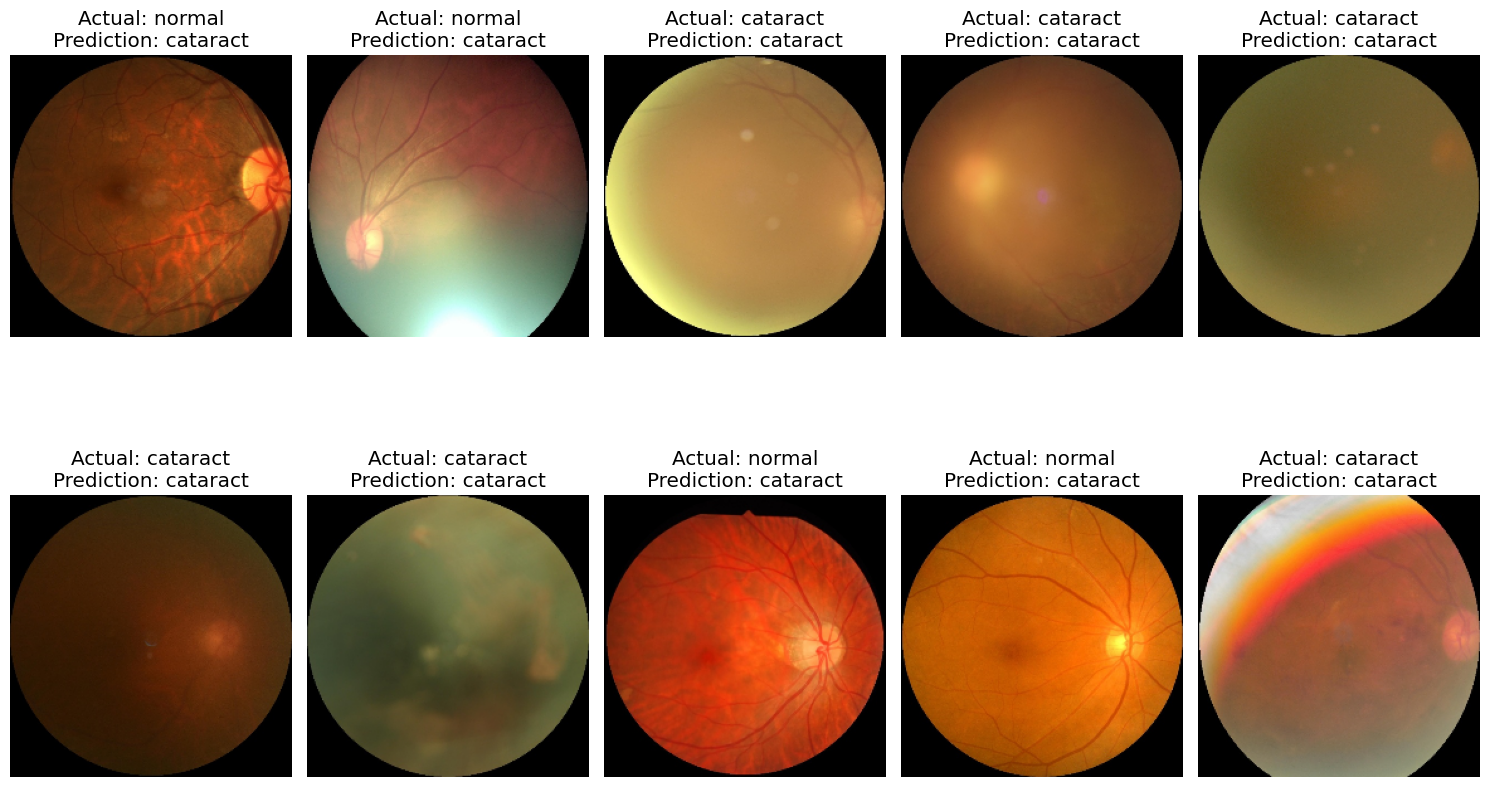

In [41]:
# Map class indices to class names for binary classification
class_names_binary = {0: 'cataract', 1: 'normal'}

plt.figure(figsize=(15, 10))

# Select a random sample of images from 'cataract' and 'normal' classes only
for i in range(10):
    # Get indices of 'cataract' and 'normal' classes
    cataract_indices = np.where(y_test[:, 0] == 1)[0]
    normal_indices = np.where(y_test[:, 1] == 1)[0]

    # Combine the indices
    all_indices = np.concatenate([cataract_indices, normal_indices])

    # Select a random index from the combined indices
    sample_index = random.choice(all_indices)

    image = x_test[sample_index]
    actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

    # Ensure that the input image has the correct shape
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

    pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

    # Convert to binary classification (0 or 1)
    binary_prediction = 1 if np.argmax(pred_category_probs) in [0, 1] else 0
    
    # Select the top predicted class for binary classification
    pred_category = class_names_binary[binary_prediction]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
    plt.axis('off')

    # Perform prediction using the modified prediksi function for binary classification
    predicted_class, confidence = prediksi(image)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%


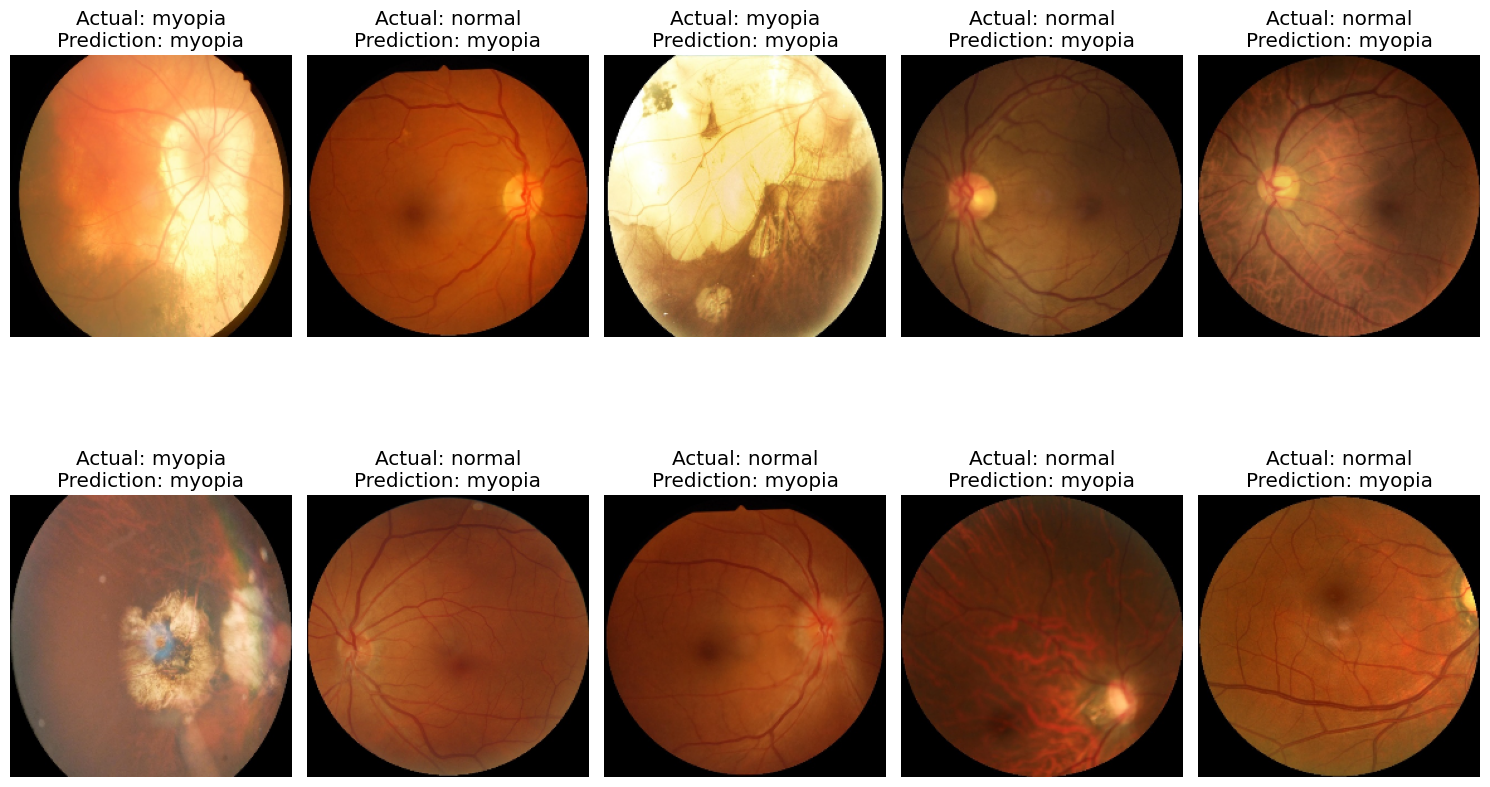

In [42]:
# Map class indices to class names for binary classification
class_names_binary = {0: 'normal', 1: 'myopia'}

plt.figure(figsize=(15, 10))

# Select a random sample of images from 'normal' and 'myopia' classes only
for i in range(10):
    # Get indices of 'normal' and 'myopia' classes
    normal_indices = np.where(y_test[:, 1] == 1)[0]
    myopia_indices = np.where(y_test[:, 5] == 1)[0]

    # Combine the indices
    all_indices = np.concatenate([normal_indices, myopia_indices])

    # Select a random index from the combined indices
    sample_index = random.choice(all_indices)

    image = x_test[sample_index]
    actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

    # Ensure that the input image has the correct shape
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

    pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

    # Convert to binary classification (0 or 1)
    binary_prediction = 1 if np.argmax(pred_category_probs) in [1, 5] else 0
    
    # Select the top predicted class for binary classification
    pred_category = class_names_binary[binary_prediction]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
    plt.axis('off')

    # Perform prediction using the modified prediksi function for binary classification
    predicted_class, confidence = prediksi(image)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 20ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 23ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 22ms/step
Predicted Class: myopia, Confidence: 100.00%
1/1 [==============================] - 0s 21ms/step
Predicted Class: myopia, Confidence: 100.00%


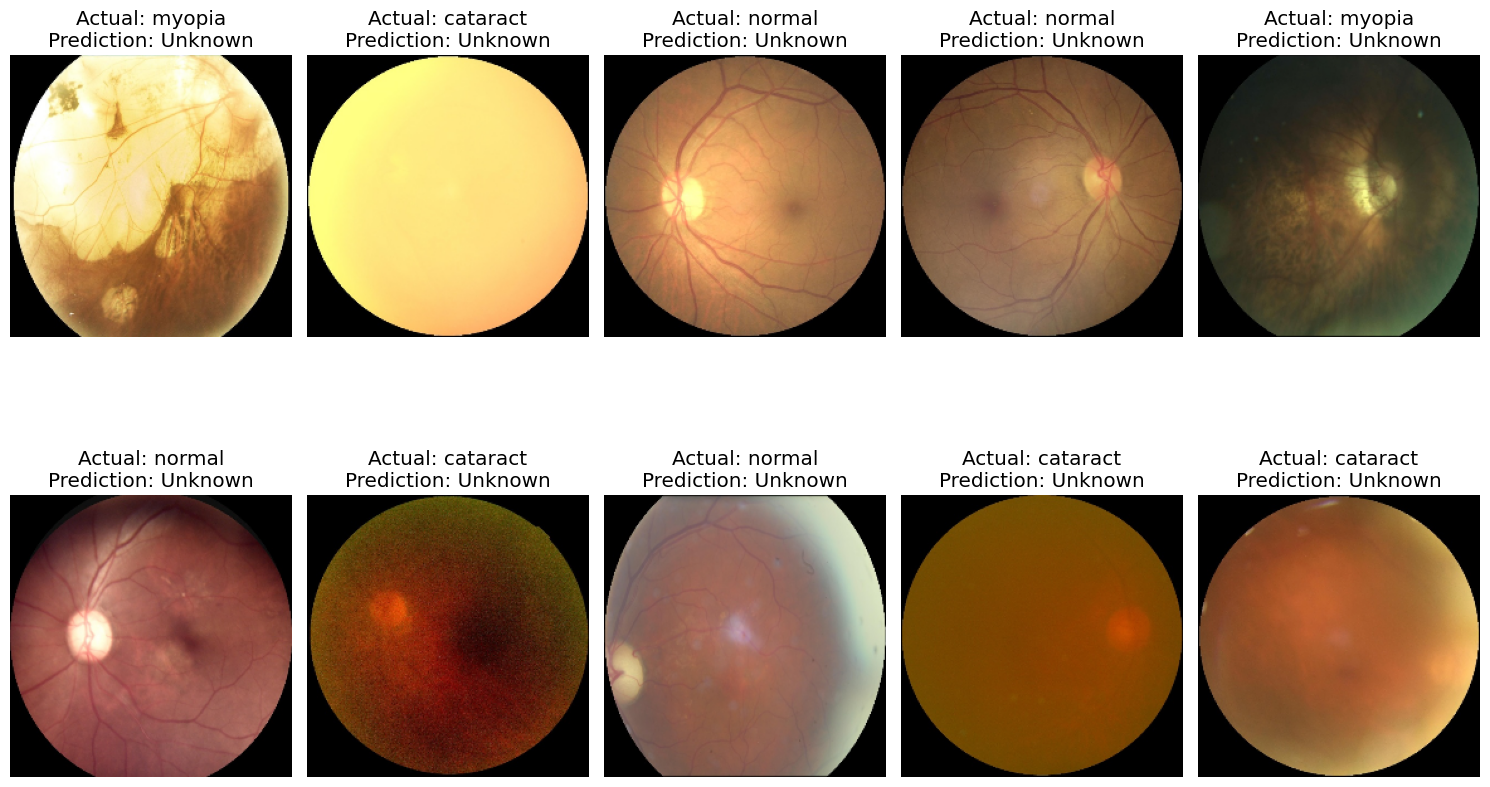

In [43]:
# Map class indices to class names for ternary classification
class_names_ternary = {0: 'normal', 1: 'cataract', 2: 'myopia'}

plt.figure(figsize=(15, 10))

# Select a random sample of images from 'normal', 'cataract', and 'myopia' classes only
for i in range(10):
    # Get indices of 'normal', 'cataract', and 'myopia' classes
    normal_indices = np.where(y_test[:, 1] == 1)[0]
    cataract_indices = np.where(y_test[:, 0] == 1)[0]
    myopia_indices = np.where(y_test[:, 5] == 1)[0]

    # Combine the indices
    all_indices = np.concatenate([normal_indices, cataract_indices, myopia_indices])

    # Select a random index from the combined indices
    sample_index = random.choice(all_indices)

    image = x_test[sample_index]
    actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

    # Ensure that the input image has the correct shape
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

    pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

    # Convert to ternary classification (0, 1, or 2)
    ternary_prediction = np.argmax(pred_category_probs)
    
    # Check if the ternary_prediction is valid
    if ternary_prediction in class_names_ternary:
        pred_category = class_names_ternary[ternary_prediction]
    else:
        pred_category = "Unknown"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
    plt.axis('off')

    # Perform prediction using the modified prediksi function for ternary classification
    predicted_class, confidence = prediksi(image)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

plt.tight_layout()
plt.show()

In [44]:
sample_index = random.choice(range(len(x_test)))
image = x_test[sample_index]
actual_category = class_names[np.argmax(y_test[sample_index])]
pred_category_probs = model.predict(np.expand_dims(image, axis=0))[0]
predicted_category = class_names[np.argmax(pred_category_probs)]

print("Actual Category:", actual_category)
print("Predicted Category:", predicted_category)

1/1 [==============================] - 0s 22ms/step
Actual Category: age-related macular degeneration
Predicted Category: myopia
